# Training Image Classification ResNet Model

1. [Introduction](#Introduction)
2. [Training the Image Classification Model](#Training-the-Image-Classification-Model)
    1. [Training parameters](#Training-parameters)
    2. [Configure training job](#Configure-training-job)
    3. [Launch training job](#Launch-training-job)
3. [Model Evaluation](#Model-Evaluation)
    1. [Create model](#Create-model)
    2. [Batch transform](#Batch-transform)
    3. [Analyze prediction results](#Analyze-prediction-results)
4. [Conclusion](#Conclusion)


## 1. Introduction

In this notebook, we will use the Amazon sagemaker image classification algorithm to train on the [PatchCamelyon dataset](https://patchcamelyon.grand-challenge.org/). 

First, we need to set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import io
import numpy as np
import pickle
import s3fs
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve

role = get_execution_role()

bucket = sagemaker.Session().default_bucket()

folder = 'lymph-node-image-classification/'

training_image = retrieve("image-classification", boto3.Session().region_name)

s3 = s3fs.S3FileSystem()
s3_client = boto3.client("s3")

CPU times: user 1.45 s, sys: 156 ms, total: 1.6 s
Wall time: 10.6 s


In [2]:
# file paths
s3_train_key = "lymph-node-image-classification/train"
s3_validation_key = "lymph-node-image-classification/validation"
s3_train = "s3://{}/{}/".format(bucket, s3_train_key)
s3_validation = "s3://{}/{}/".format(bucket, s3_validation_key)

## 2. Training the Image Classification Model

We are using [PatchCamelyon](https://patchcamelyon.grand-challenge.org/) dataset, which contains 327,680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating presence of metastatic tissue. The train/validation/test split is 80/10/10. 

We already prepared the data in `Augmented Manifest` format in the previous notebook, so we are ready to start training the model using the best parameters discovered from our hyperparameter tuning.


### a) Training parameters
First, we will need to specify the parameters for our training job. This includes input specification, output specification, and resource config.

We also need to select our hyperparameters from our tuning in the previous notebook:

* **num_layers**: The number of layers (depth) for the network. We will use **34**.
* **num_training_samples**: This is the total number of training samples, which is **262,144** for our data.
* **num_classes**: This is the number of output classes for the new dataset. Our problem is binary, so this will be **2**.
* **augmentation_type**: Data augmentation type. We will use **`crop`** to randomly crop and flip the images horizontally
* **epochs**: Number of training epochs - **10**
* **learning_rate**: Learning rate for training - **0.009**
* **lr_scheduler_factor**: The ratio to reduce learning rate used in conjunction with the `lr_scheduler_step` parameter, defined as lr_new = lr_old * lr_scheduler_factor - **0.1**
* **lr_scheduler_step**: The epochs at which to reduce the learning rate - **2,6**
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run - **64**
* **optimizer**: The optimizer type. `sgd`, `adam`, `rmsprop`, and `nag` are all offered. We will select the popularly used algorithm for computer vision, **`adam`**, a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
* **precision_dtype**: The precision of the weights used for training. We will be using half precision **`(float16)`** instead of single precision `(float32)` in order to reduce memory consumption without sacrificing accuracy.
* **use_pretrained_model**: Use transfer learning instead of full training, by initializing weights with a pretrained model - **1**
* **eps**: A small constant for numerical stability. The default is 1e-8, but for image classification it is recommended to use a value of 1.0 or 0.1. In this case, we choose **0.1**

In [3]:
# Hyperparameters
num_layers = "34" 
image_shape = "3,96,96" 
num_training_samples = "262144"
num_classes = "2"
mini_batch_size = "64" 
epochs = "10"
learning_rate = "0.009"
precision_dtype="float16"
augmentation_type="crop" 
optimizer="adam"
lr_scheduler_factor = "0.1"
lr_scheduler_step = "2,6" 
use_pretrained_model = 1
eps = 0.1

### b) Configure training job
Run the training job using SageMaker's CreateTrainingJob API

In [4]:
%%time
import time
from time import gmtime, strftime

s3 = boto3.client("s3")
# create unique job name
job_name_prefix = "34L-ADAM-imageclassification"
job_name = job_name_prefix + "-" + time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
training_params = {
    # specify the training image
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "Pipe"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, job_name_prefix)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.p3.2xlarge", "VolumeSizeInGB": 50},
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "augmentation_type": augmentation_type,
        "precision_dtype": precision_dtype,
        "optimizer": optimizer,
        "lr_scheduler_factor": lr_scheduler_factor,
        "lr_scheduler_step": lr_scheduler_step,
        "use_pretrained_model": use_pretrained_model
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 10800},
    #"EnableManagedSpotTraining": True,
    # Training data should be inside a subdirectory called "train"
    # Validation data should be inside a subdirectory called "validation"
    # The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "AttributeNames": ["image-ref", "class"],
                    "S3Uri": s3_train + 'augmented_manifest_train.json',
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-recordio",
            "InputMode": "Pipe",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "AttributeNames": ["image-ref", "class"],
                    "S3Uri": s3_validation + 'augmented_manifest_validation.json',
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-recordio",
            "InputMode": "Pipe",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None",
        },
    ],
}
print("Training job name: {}".format(job_name))
print(
    "\nInput Data Location: {}".format(
        training_params["InputDataConfig"][0]["DataSource"]["S3DataSource"]
    )
)

Training job name: 34L-ADAM-imageclassification--2021-10-09-02-35-55

Input Data Location: {'S3DataType': 'AugmentedManifestFile', 'AttributeNames': ['image-ref', 'class'], 'S3Uri': 's3://sagemaker-us-east-1-513033806411/lymph-node-image-classification/train/augmented_manifest_train.json', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 5.89 ms, sys: 182 µs, total: 6.07 ms
Wall time: 5.88 ms


### c) Launch training job
After setting training parameters, we kick off training and poll for status until training is completed.

In [5]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name="sagemaker")
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print("Training job current status: {}".format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info["TrainingJobStatus"]
    print("Training job ended with status: " + status)
except:
    print("Training failed to start")
    # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)["FailureReason"]
    print("Training failed with the following error: {}".format(message))

In [11]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info["TrainingJobStatus"]
print("Training job ended with status: " + status)

Training job ended with status: Completed


If you see the message,

> `Training job ended with status: Completed`

then that means training successfully completed and the output model was stored in the output path specified by `training_params['OutputDataConfig']`.

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

## 3. Model Evaluation

### a) Create Model

We now create a SageMaker Model from the training output. Using the model we can create a Batch Transform Job or an Endpoint Configuration.

In [8]:
%%time

sage = boto3.Session().client(service_name="sagemaker")

job_name = '34L-ADAM-imageclassification--2021-10-09-02-35-55'

model_name = "PCAM-image-classification-model" + time.strftime(
    "-%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

hosting_image = retrieve("image-classification", boto3.Session().region_name)

primary_container = {
    "Image": hosting_image,
    "ModelDataUrl": model_data,
}

create_model_response = sage.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

PCAM-image-classification-model-2021-10-04-17-55-20
s3://sagemaker-us-east-1-513033806411/34L-ADAM-imageclassification--2021-10-09-02-35-55/output/34L-ADAM-imageclassification--2021-10-09-02-35-55/output/model.tar.gz
arn:aws:sagemaker:us-east-1:513033806411:model/pcam-image-classification-model-2021-10-09-02-42-20
CPU times: user 88.7 ms, sys: 12.3 ms, total: 101 ms
Wall time: 700 ms


### b) Batch Transform

We now create a SageMaker Batch Transform job using the model created above to perform batch prediction.

In [9]:
batch_input = "s3://{}/lymph-node-image-classification/images/color/test/".format(bucket)
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
batch_job_name = "PCAM-image-classification-model" + timestamp
request = {
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {"S3OutputPath": "s3://{}/{}/output".format(bucket, batch_job_name)},
    "TransformInput": {
        "DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": batch_input}},
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None",
    },
    "TransformResources": {"InstanceType": "ml.p3.2xlarge", "InstanceCount": 1},
}

print("Transform job name: {}".format(batch_job_name))
print("\nInput Data Location: {}".format(batch_input))

Transform job name: PCAM-image-classification-model-2021-10-09-02-42-20

Input Data Location: s3://sagemaker-us-east-1-513033806411/lymph-node-image-classification/images/color/test/


In [11]:
sagemaker = boto3.client("sagemaker")
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while True:
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response["TransformJobStatus"]
    if status == "Completed":
        print("Transform job ended with status: " + status)
        break
    if status == "Failed":
        message = response["FailureReason"]
        print("Transform failed with the following error: {}".format(message))
        raise Exception("Transform job failed")
    time.sleep(30)

Created Transform job with name:  PCAM-image-classification-model-2021-10-09-02-42-20
Transform job ended with status: Completed


After the job completes, let's gather our prediction results.

In [3]:
s3 = s3fs.S3FileSystem()

# Observed values for test
def readArrayFromS3(name):
    """Load pickle file as np array from S3"""
    return np.load(s3.open('{}/{}'.format(bucket, name)), allow_pickle=True)

# Load test labels
test_y = readArrayFromS3(folder + 'test_y/camelyonpatch_level_2_split_test_y.pkl')

In [10]:
import json

s3_client = boto3.client("s3")

def list_objects(s3_client, bucket, prefix):
    """Get list of all output objects"""
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    objects = [content["Key"] for content in response["Contents"]]
    return objects

def get_label(s3_client, bucket, prefix):
    """
    Get predictions
    
    Returns:
    ----
    {tuple} -- (image index, class, predicted probability)
    
    """
    filename = 'outputs/' + prefix.split("/")[-1]
    s3_client.download_file(bucket, prefix, filename)
    jpg_idx = int(filename.split(".")[0][13:])
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data["prediction"])
        probability = data["prediction"][index]
    return jpg_idx, index, probability

# observed
observed = test_y.flatten()

#outputs
outputs = [batch_job_name+'/output/test_'+str(i)+'.jpg.out' for i in range(len(observed))]

# Load prediction results
predictions = [get_label(s3_client, bucket, prefix) for prefix in outputs]

# Sort predictions based on jpeg index
predictions = sorted(predictions, key=lambda x: x[0])

In [13]:
#print first 10 predictions
predictions[:10]

[(0, 0, 0.9669764637947083),
 (1, 1, 0.9961079955101013),
 (2, 1, 0.639876663684845),
 (3, 1, 0.9999039173126221),
 (4, 1, 0.6065276265144348),
 (5, 0, 0.8801805377006531),
 (6, 1, 0.8618873357772827),
 (7, 1, 0.8382167816162109),
 (8, 1, 0.9317114353179932),
 (9, 0, 0.9743373394012451)]

In [18]:
import pandas as pd

# Create predictions dataframe
pred_df = pd.DataFrame(columns=["Index","Predicted","Probability"], data=predictions)
pred_df["Observed"] = observed

In [21]:
pred_df.head()

,Index,Predicted,Probability,Observed
0,0,0,0.966976,0
1,1,1,0.996108,1
2,2,1,0.639877,0
3,3,1,0.999904,1
4,4,1,0.606528,1


In [29]:
# Output predictions 
pred_df.to_csv('predictions.csv', index=False)

In [3]:
# Checkpoint - load predictions
import pandas as pd
pred_df = pd.read_csv('predictions.csv')

### c) Analyze Prediction Results

SageMaker's Image Classification algorithm provides probabilities for the the two classes. Before computing AUC-ROC, we should convert the probabilities for each class to the probability of positive metastatic cancer. We can easily do this with (1-probability) for predicitions classified as "0".

In [4]:
# Adjust probability for computing AUC-ROC
pred_df['Probability'] = pred_df.apply(lambda row: 1-row['Probability'] if row['Predicted'] == 0 else row['Probability'], axis=1)

Now that we have the probabilities, let's plot the ROC curve to evaluate the quality of our model.

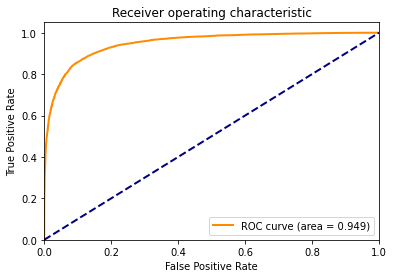

In [11]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(pred_df['Observed'],  pred_df['Probability'])
auc = metrics.roc_auc_score(pred_df['Observed'],  pred_df['Probability'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
F1 = metrics.f1_score(pred_df['Observed'],  pred_df['Predicted'])
precision = metrics.precision_score(pred_df['Observed'],  pred_df['Predicted'])
recall = metrics.recall_score(pred_df['Observed'],  pred_df['Predicted'])
acc = metrics.accuracy_score(pred_df['Observed'],  pred_df['Predicted'])
print(f"Precision: {round(precision,3)}")
print(f"Recall: {round(recall,3)}")
print(f"F1 score: {round(F1,3)}")
print(f"Accuracy: {round(acc,3)}")
print(f"AUC: {round(auc,3)}")

Precision: 0.934
Recall: 0.776
F1 score: 0.848
Accuracy: 0.861
AUC: 0.949


Our precision is good, but we are predicting cancer, which means false negatives are extremely costly so we should be more concerned with recall. We can visualize our misclassifications in the confusion matrix below.

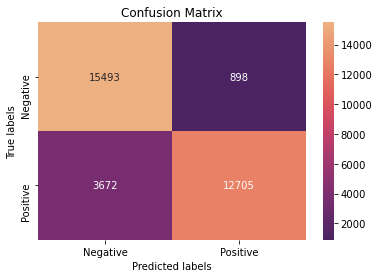

In [14]:
# Plot confusion matrix
cm = metrics.confusion_matrix(pred_df['Observed'], pred_df['Predicted'], labels=[0,1])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="flare_r")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

Clearly there is an imbalance as the number of false negatives is four times greater than false positives. Let's experiment with the prediction threshold and see if we can balance our confusion matrix without sacrificing too much accuracy.

In [15]:
# New prediction based on updated threshold
pred_df['New Prediction'] = pred_df.apply(lambda row: 1 if row['Probability'] > 0.25 else 0, axis=1)

In [16]:
F1 = metrics.f1_score(pred_df['Observed'],  pred_df['New Prediction'])
precision = metrics.precision_score(pred_df['Observed'],  pred_df['New Prediction'])
recall = metrics.recall_score(pred_df['Observed'],  pred_df['New Prediction'])
acc = metrics.accuracy_score(pred_df['Observed'],  pred_df['New Prediction'])
print(f"Precision: {round(precision,3)}")
print(f"Recall: {round(recall,3)}")
print(f"F1 score: {round(F1,3)}")
print(f"Accuracy: {round(acc,3)}")

Precision: 0.88
Recall: 0.876
F1 score: 0.878
Accuracy: 0.878


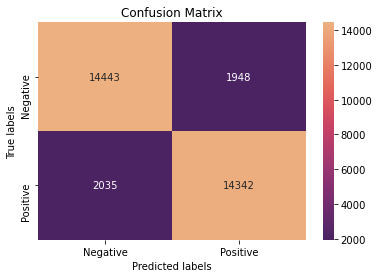

In [18]:
# Plot updated confusion matrix
cm = metrics.confusion_matrix(pred_df['Observed'], pred_df['New Prediction'], labels=[0,1])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="flare_r");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative','Positive']); ax.yaxis.set_ticklabels(['Negative','Positive']);

## Conclusion
By changing our threshold from 0.5 to 0.25, we have balanced the type I and II errors, and actually improved all of our metrics with the exception of precision. Our final model **accuracy is 87.8%** on the test set. In the next notebook, we will deploy our model for realtime inference.